# 네이버 / 다음

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from matplotlib import style
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from pymongo import MongoClient

import datetime
from datetime import timedelta
import random
import hashlib
import collections

style.use('ggplot')
%matplotlib inline
keywords = ['이해찬','초록우산어린이재단', '산업혁명', '강원도', '신한은행', '상견례', '춘천시장', '카카오커머스', '초록우산', '오징어게임', 'sk가스', '블랙핑크', '4차산업혁명위원회', '오대훈', '디카르고', '행복', '최문순', '원주시', '맨유', 'mz세대', '아이폰13', '아스트라', '야구', '도이치모터스', '한국전력', '국세청', '20대', '오징어', '출마', '무소속', '위하고', '월드시리즈', '영림원', 'EY한영', '할인', '얀센', '대선', '티맥스', '나경원', '카카오커머스병합', '소나기', '빅뱅', '국민의힘', '디피', '산업단지관리공단', '누누', '솔샤르', '안철수', '육군', 'minsriver', '한국전력공사', '정세균', '이재수', '중앙지검', '오세훈', '더존비즈온', '백신', '모더나', '이낙연', '마스크', '로지스팟', '녹십자홀딩스', '매출채권팩토링', '광주', '이명박', '비트코인', '강원대학교', '이벤트', '개리', '탬파베이', '얀센백신', '지원금', 'mlb', '홍준표', '맨체스터유나이티드', '콘테', '황상무', '무지개', '삼성라이온즈', '화천대유', '정책', '게임', '유승민', '삼일회계법인', '이광재', '제주도', '키워드', '권지용', '여행', '테스트', '강릉', '윤희숙', '화이자백신', '문재인', '바베큐', '더존', 'GC녹십자홀딩스', '창원시', '민주당', '강민', '배구', '이재명', '코로나', '춘천', '윤석열', '4차위', '부산', '웹케시', '송영길', '애틀란타브레이브스', '노트북', '메타버스', '겨울', '축구', '공약', '김인규', '리버풀', '현대백화점', '김연경', '사천', '월드컵', '카카오', '한림대학교', '날씨', '공정', '정윤환', '야구장', '김용택', 'NFT', '트위터', '화이자', '향수', 'ERP']

client = MongoClient('localhost', 27017, username='mongo', password='mongo')
db = client.news
collection = db.related_keyword


naver_dictionary = {}
daum_dictionary = {}

def naver_crawling_related_word(word_list, n):
    if n==0:
        print("크롤링 종료")
    else:
        merge_df = pd.DataFrame()

        for i in range(len(word_list)):
            temp_df = pd.DataFrame()
            temp_list = []

            url = f'https://search.naver.com/search.naver?where=nexearch&query={word_list[i]}'

            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'lxml')

            ul_inner = soup.find('ul', {'class':'lst_related_srch _list_box'})

            try:
                keyword_list = soup.find('ul', {'class':'lst_related_srch _list_box'}).find_all('li')
            except:
                if pd.isna(ul_inner):
                    try:
                        keyword_list = soup.find('ul', {'class':'lst_related_srch _list_box'}).find_all('li')
                    except:
                        keyword_list = []

            # span_list 가 공백일 때 예외 처리
            if len(keyword_list) == 0:
                pass
            else:
                for k, word in enumerate(keyword_list):
                    if len(keyword_list[k].text.replace(word_list[i],'').strip()) == 1:
                        temp_list.append(keyword_list[k].text.strip())
                    else:
                          temp_list.append(keyword_list[k].text.strip())

                temp_df['sub_word'] = temp_list
                temp_df['sup_word'] = word_list[i]
                temp_df = pd.DataFrame(temp_df, columns=['sup_word', 'sub_word'])

                merge_df = pd.concat([merge_df, temp_df], axis=0)
        naver_dictionary[n] = merge_df
        # 재귀호출
        pass_word_list = merge_df['sub_word'].values

        print('네이버 크롤링 시작')
        naver_crawling_related_word(pass_word_list, n-1)

def daum_crawling_related_word(word_list, n):
    if n==0:
        print("크롤링 종료")
    else:
        merge_df = pd.DataFrame()

        for i in range(len(word_list)):
            temp_df = pd.DataFrame()
            temp_list = []

            url = f'https://search.daum.net/search?w=tot&DA=YZR&t__nil_searchbox=btn&sug=&sugo=&q={word_list[i]}'

            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'lxml')

            div_inner = soup.find('div', {'class':'list_keyword type2'})

            try:
                div_inner = soup.find('div', {'class':'list_keyword type2'})
                span_list = div_inner.find_all('span', {'class':'wsn'})
            except:
                if pd.isna(div_inner):
                    try:
                        div_inner = soup.find('div', {'class':'list_keyword'})
                        span_list = div_inner.find_all('span', {'class':'wsn'})
                    except:
                        span_list = []

            # span_list 가 공백일 때 예외 처리
            if len(span_list) == 0:
                pass
            else:
                for k, word in enumerate(span_list):
                    if len(span_list[k].text.replace(word_list[i],'').strip()) == 1:
                        temp_list.append(span_list[k].text)
                    else:
                        temp_list.append(span_list[k].text)

                temp_df['sub_word'] = temp_list
                temp_df['sup_word'] = word_list[i]
                temp_df = pd.DataFrame(temp_df, columns=['sup_word', 'sub_word'])

                merge_df = pd.concat([merge_df, temp_df], axis=0)

        daum_dictionary[n] = merge_df

        # 재귀호출
        pass_word_list = merge_df['sub_word'].values
        print('다음 크롤링 시작')
        daum_crawling_related_word(pass_word_list, n-1)    
        
word_list = ['더존비즈온']
try:
    naver_crawling_related_word(word_list, 2)
    daum_crawling_related_word(word_list, 2)
except Exception as e:
    print(e)
daum_dictionary[2].columns = ['sup_word', 'sub_word1']
daum_dictionary[1].columns = ['sub_word1', 'sub_word2']

naver_dictionary[2].columns = ['sup_word', 'sub_word1']
naver_dictionary[1].columns = ['sub_word1', 'sub_word2']


네이버 크롤링 시작
네이버 크롤링 시작
크롤링 종료
다음 크롤링 시작
다음 크롤링 시작
크롤링 종료


In [2]:
ㄴ

['더존비즈온 주가', '더존비즈온 전망', '더존비즈온 분석', '더존비즈온 블라인드', '더존비즈온 어떤가요', '더존비즈온 김용우', '더존비즈온 연봉', '더존비즈온 채용']


,sub_word1,sup_word
0,더존비즈온 주가,더존비즈온
1,더존비즈온 전망,더존비즈온
2,더존비즈온 분석,더존비즈온
3,더존비즈온 블라인드,더존비즈온
4,더존비즈온 어떤가요,더존비즈온
5,더존비즈온 김용우,더존비즈온
6,더존비즈온 연봉,더존비즈온
7,더존비즈온 채용,더존비즈온


In [3]:
result_df = pd.concat([daum_dictionary[2], naver_dictionary[2],google_df])
result_df = result_df.reset_index()
result_df = result_df.drop('index',1)

result_df.drop_duplicates()

<ipython-input-3-7440c4de0926>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  result_df = result_df.drop('index',1)


,sup_word,sub_word1
0,더존비즈온,더존비즈온 주가
1,더존비즈온,더존비즈온 주가 전망
2,더존비즈온,더존비즈온 연봉
3,더존비즈온,펄어비스
4,더존비즈온,더존비즈온 실적
5,더존비즈온,더존비즈온 고객센터
6,더존비즈온,더존비즈온 채용
7,더존비즈온,더존비즈온 김용우
8,더존비즈온,더존비즈온 배당
9,더존비즈온,더존비즈온 한전


In [4]:
import hashlib
import hmac
import base64

import requests
import time
import random
import requests
from powernad.API import RelKwdStat
import pandas as pd

BASE_URL = 'https://api.naver.com'
API_KEY = '*'
SECRET_KEY = '*'
CUSTOMER_ID = '*'

def naverKwdApi(keyword):
    data_list = []
    
    relKwdStat = RelKwdStat.RelKwdStat(BASE_URL, API_KEY, SECRET_KEY, CUSTOMER_ID)
    time.sleep(0.5)
    
    kwdDataList = relKwdStat.get_rel_kwd_stat_list(None, hintKeywords=keyword, showDetail='1')
    
    for outdata in kwdDataList:
        relKeyword = outdata.relKeyword # 연관 키워드
        monthleyPcQcCnt = outdata.monthlyPcQcCnt # 30일간 PC 조회수
        monthleyMobileQcCnt = outdata.monthlyMobileQcCnt # 30일간 모바일 조회수
        monthlyAveMobileClkCnt = outdata.monthlyAveMobileClkCnt # 4주간 평균 모바일 클릭수
        monthlyAvePcCtr = outdata.monthlyAvePcCtr # 4주간 평균 PC 클릭율
        monthlyAveMobileCtr = outdata.monthlyAveMobileCtr # 4주간 평균 모바일 클릭율
        plAvgDepth = outdata.plAvgDepth # 4주간 평균 PC 광고수
        compIdx = outdata.compIdx
        
        if monthleyPcQcCnt == '< 10':
            monthleyPcQcCnt = 0
        
        if monthleyMobileQcCnt == '< 10':
            monthleyMobileQcCnt = 0
            
#         print(relKeyword,monthleyMobileQcCnt)
        json_obj = {
            '키워드' : keyword,
            '연관 키워드':relKeyword,
            '월간 PC 검색수':monthleyPcQcCnt,
            '월간 Mobile 검색수':monthleyMobileQcCnt,
            '검색수합계': int(monthleyPcQcCnt)+int(monthleyMobileQcCnt),
            '월평균 PC 클릭수' : monthlyAvePcCtr,
            '월평균 Mobile 클릭수' : monthlyAveMobileClkCnt,
            '월평균 PC 클릭율': monthlyAvePcCtr,
            '월평균 Mobile 클릭율':monthlyAveMobileCtr,
            '경쟁정도':compIdx,
            '월평균노출광고수':plAvgDepth
        }
        data_list.append(json_obj)

    df = pd.DataFrame(data_list)
    return df

# df = naverKwdApi("더존비즈온")
# df = df[['키워드', '연관 키워드','검색수합계']]
# df = df.sort_values(by=['검색수합계'], axis=0, ascending=False)

# df.head(150)

In [5]:

sup_li = []
sub_li1 = []
sub_li2 = []

keyword = '더존비즈온'
sup_li.append(keyword)
sub_li1.append(keyword)
for i in set(result_df['sub_word1'].values):
    try:
        sub_li1.append(i.replace(" ", "").strip())
    except Exception as e:
        print("xxx",e)
        continue

# for i in set(total_df['sub_word2'].values):
#     try:
#         sub_li2.append(i.replace(" ", "").strip())
#     except Exception as e:
#         print("xxx",e)
#         continue


In [6]:
import time

sup_re = []
sub_re1 = []

for keyword in sup_li:
    df = naverKwdApi(keyword)
    try:
        df = df[['키워드', '검색수합계']]
    except Exception as e:
        print(e, df.columns)
    df = df.sort_values(by=['검색수합계'], axis=0, ascending=False)
    df.columns = ['sup_word', 'views']
    
    print(list(df.loc[0].values))
    sup_re.append(list(df.loc[0].values))
    
print("---sub111---")
for keyword in sub_li1:
    df = naverKwdApi(keyword)
    try:
        df = df[['키워드', '검색수합계']]
    except Exception as e:
        print(e, df.columns)
    df = df.sort_values(by=['검색수합계'], axis=0, ascending=False)
    df.columns = ['sub_word1', 'views']
    
    print(list(df.loc[0].values))
    sub_re1.append(list(df.loc[0].values))


['더존비즈온', 97400]
---sub111---
['더존비즈온', 97400]
['더존비즈온블라인드', 20]
['더존비즈온어떤가요', 0]
['더존비즈온배당', 170]
['더존비즈온주가전망', 70]
['더존비즈온세금계산서', 10]
['카카오', 2984100]
['더존비즈온김용우', 350]
['더존비즈온배당금', 180]
['더존비즈온고객센터', 110]
['더존비즈온한전', 50]
['더존비즈온전망', 90]
['더존스마트a', 4880]
['더존비즈온실적', 90]
['춘천더존비즈온', 20]
['더존비즈온을지로', 10]
['더존비즈온회장', 10]
['펄어비스', 411700]
['더존이러닝', 1680]
['더존비즈온연봉', 460]
['더존비즈온msci', 180]
['더존비즈온분석', 40]
['더존비즈온채용', 530]
['더존비즈온코로나', 0]
['더존비즈온주식', 120]
['더존비즈온클라우드', 30]
['더존비즈온주가', 22380]
['더존비즈온목표주가', 20]


In [9]:
sup_df = pd.DataFrame(sup_re, columns=['keyword', 'views'])
re_df = pd.DataFrame(sub_re1, columns=['sub_word', 'views'])
re_df['keyword'] = "더존비즈온"
re_df

,sub_word,views,keyword
0,더존비즈온,97400,더존비즈온
1,더존비즈온블라인드,20,더존비즈온
2,더존비즈온어떤가요,0,더존비즈온
3,더존비즈온배당,170,더존비즈온
4,더존비즈온주가전망,70,더존비즈온
5,더존비즈온세금계산서,10,더존비즈온
6,카카오,2984100,더존비즈온
7,더존비즈온김용우,350,더존비즈온
8,더존비즈온배당금,180,더존비즈온
9,더존비즈온고객센터,110,더존비즈온


In [10]:
sup_df

,keyword,views
0,더존비즈온,97400


그리기 시작
{'더존비즈온': 97400, '더존비즈온블라인드': 20, '더존비즈온어떤가요': 0, '더존비즈온배당': 170, '더존비즈온주가전망': 70, '더존비즈온세금계산서': 10, '카카오': 2984100, '더존비즈온김용우': 350, '더존비즈온배당금': 180, '더존비즈온고객센터': 110, '더존비즈온한전': 50, '더존비즈온전망': 90, '더존스마트a': 4880, '더존비즈온실적': 90, '춘천더존비즈온': 20, '더존비즈온을지로': 10, '더존비즈온회장': 10, '펄어비스': 411700, '더존이러닝': 1680, '더존비즈온연봉': 460, '더존비즈온msci': 180, '더존비즈온분석': 40, '더존비즈온채용': 530, '더존비즈온코로나': 0, '더존비즈온주식': 120, '더존비즈온클라우드': 30, '더존비즈온주가': 22380, '더존비즈온목표주가': 20}


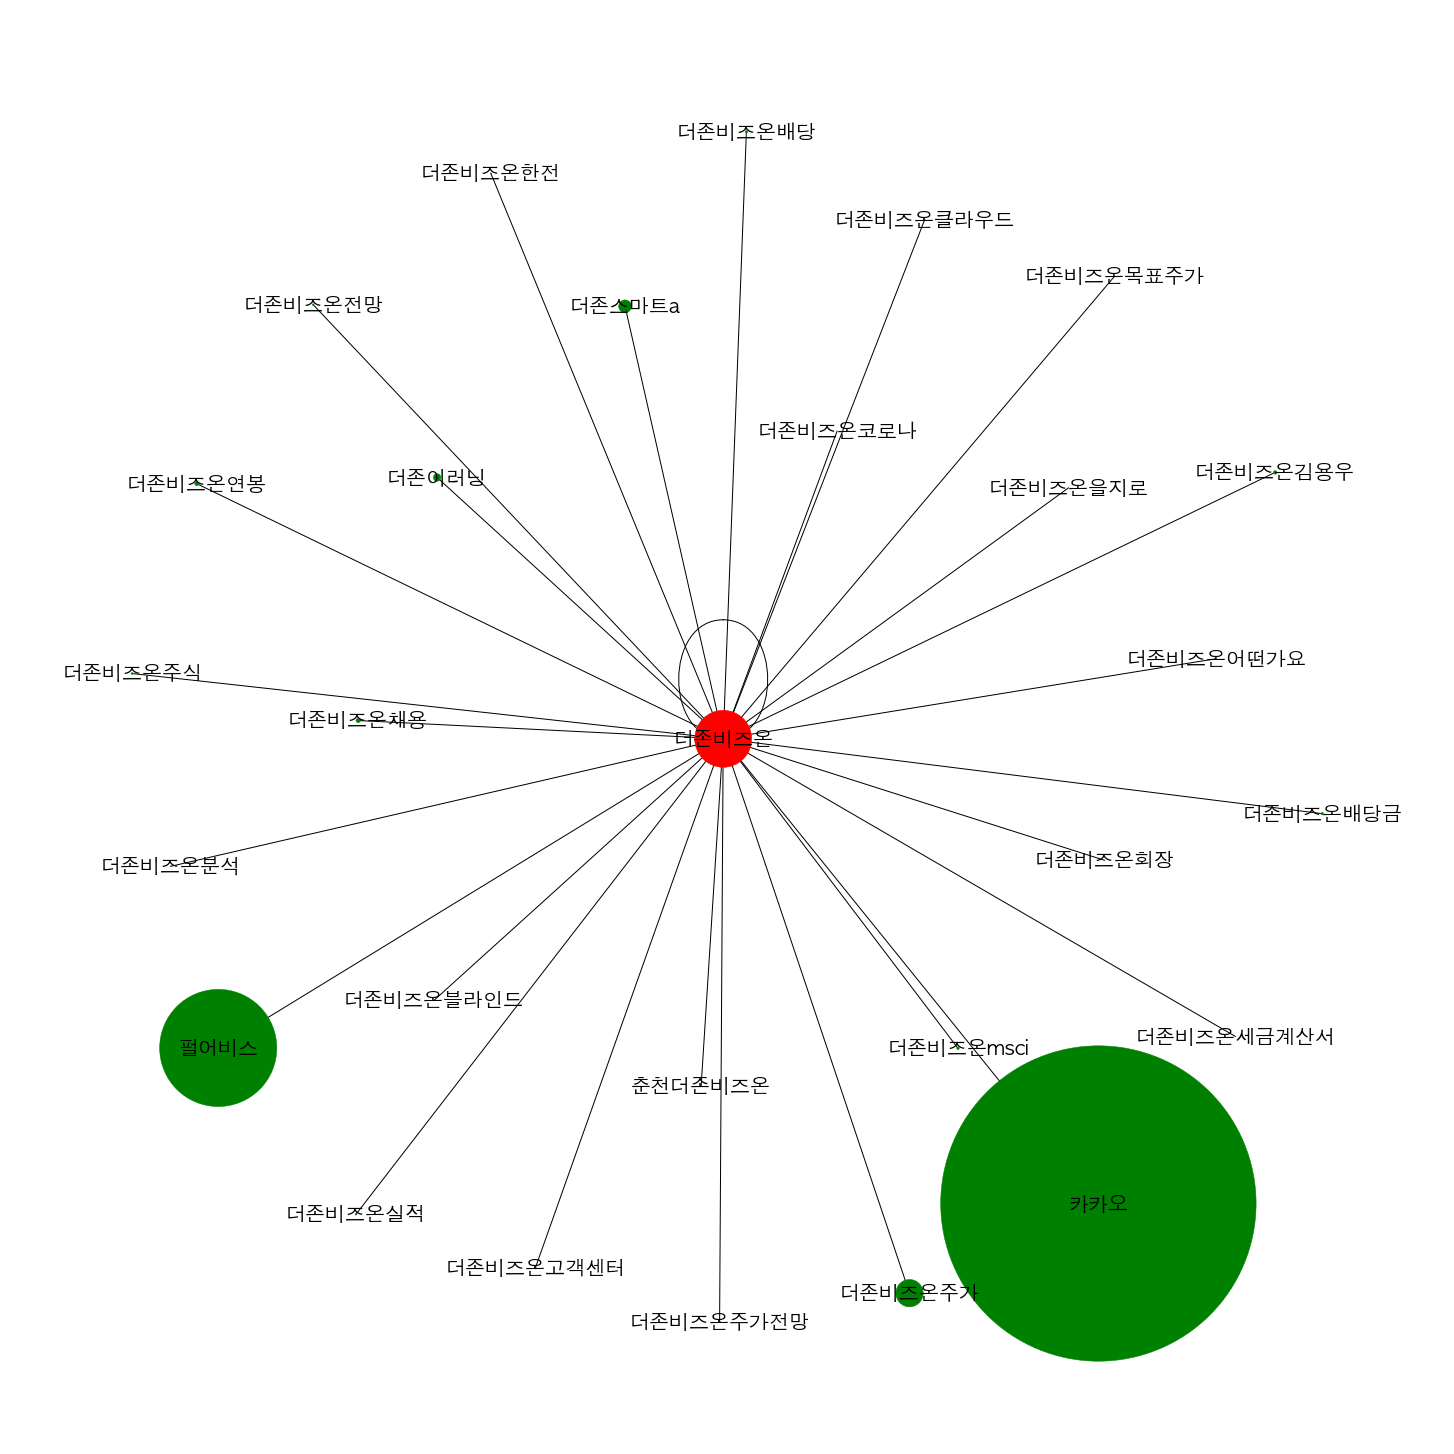

In [12]:
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib 

import networkx as nx
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from matplotlib import style
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

import datetime
from datetime import timedelta
import random
import hashlib
import collections

style.use('ggplot')
%matplotlib inline


def netword_drawing(re_df):
    print("그리기 시작")
    G = nx.Graph()
    
    for sup in list(re_df['keyword'].values):
        G.add_node(sup)
        
        for sub1 in list(re_df['sub_word'].values):
            G.add_node(sub1)
            G.add_edge(sup, sub1)
            
#             for sub2 in list(set(sub_df2['keyword'].values)):
#                 G.add_node(sub2)
#                 G.add_edge(sub1, sub2)
                
    color_map = []
    for node in G:
        if node == re_df['keyword'].values[0]:
            color_map.append('red')
        else:
            color_map.append('green')      
    
    plt.figure(figsize=(20,20))
#     d = dict(G.degree(list(set(re_df['views']))))
#     pos = nx.shell_layout(G)
    d = dict(zip(re_df['sub_word'], re_df['views']))
    print(d)
    
       
    nx.draw(G, nodelist=list(d), node_size=[int(v)/30 for v in d.values()], edge_cmap=plt.cm.OrRd,font_family='AppleGothic', font_size=20, node_color = color_map, with_labels = True, font_weight='bold')

    plt.axis('off')
    plt.savefig('networx_picture_'+re_df['keyword'].values[0]+'.png')
    plt.show()

netword_drawing(re_df)